In [29]:
%matplotlib inline


import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

import torch
import torch.optim as optim
from torchvision import transforms, models
from torchvision.utils import save_image

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg = models.vgg19(pretrained = True).features

# Congelar todos los parámetros del VGG19 por que solo estamos optimizando para una sola imagen
for param in vgg.parameters():
    param.requires_grad_(False)

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [31]:
def cargar_imagen(directorio_imagen, tamaño_maximo=500, shape = None):
    '''Cargar y transformar una imagen asegurando que su tamaño sea menor o igual a 512 píxeles
    en ambas dimensiones.'''
    imagen = Image.open(directorio_imagen).convert('RGB')
    
    # resize image if larger than tamaño_maximo
    if max(imagen.size) > tamaño_maximo:
        imagen = imagen.resize((tamaño_maximo, tamaño_maximo))
    
    # apply transformations and return image as a tensor
    transform = transforms.Compose([
                    transforms.Resize(512),
                    transforms.ToTensor()])
    
    imagen = transform(imagen)[:3, :, :].unsqueeze(0)
    return imagen



In [32]:
content = cargar_imagen('../data/content/austin.jpg').to(device)
style = cargar_imagen('../data/style/theMuse.jpg', shape = content.shape[-2:]).to(device)

In [33]:
def im_convert(tensor):
    ''' Presentar imagen como Tensor'''
    imagen = tensor.to('cpu').clone().detach()
    imagen = imagen.numpy().squeeze()
    imagen = imagen.transpose(1, 2, 0)
    #imagen = imagen * np.array((0.029, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    imagen = imagen.clip(0, 1)
    
    return imagen

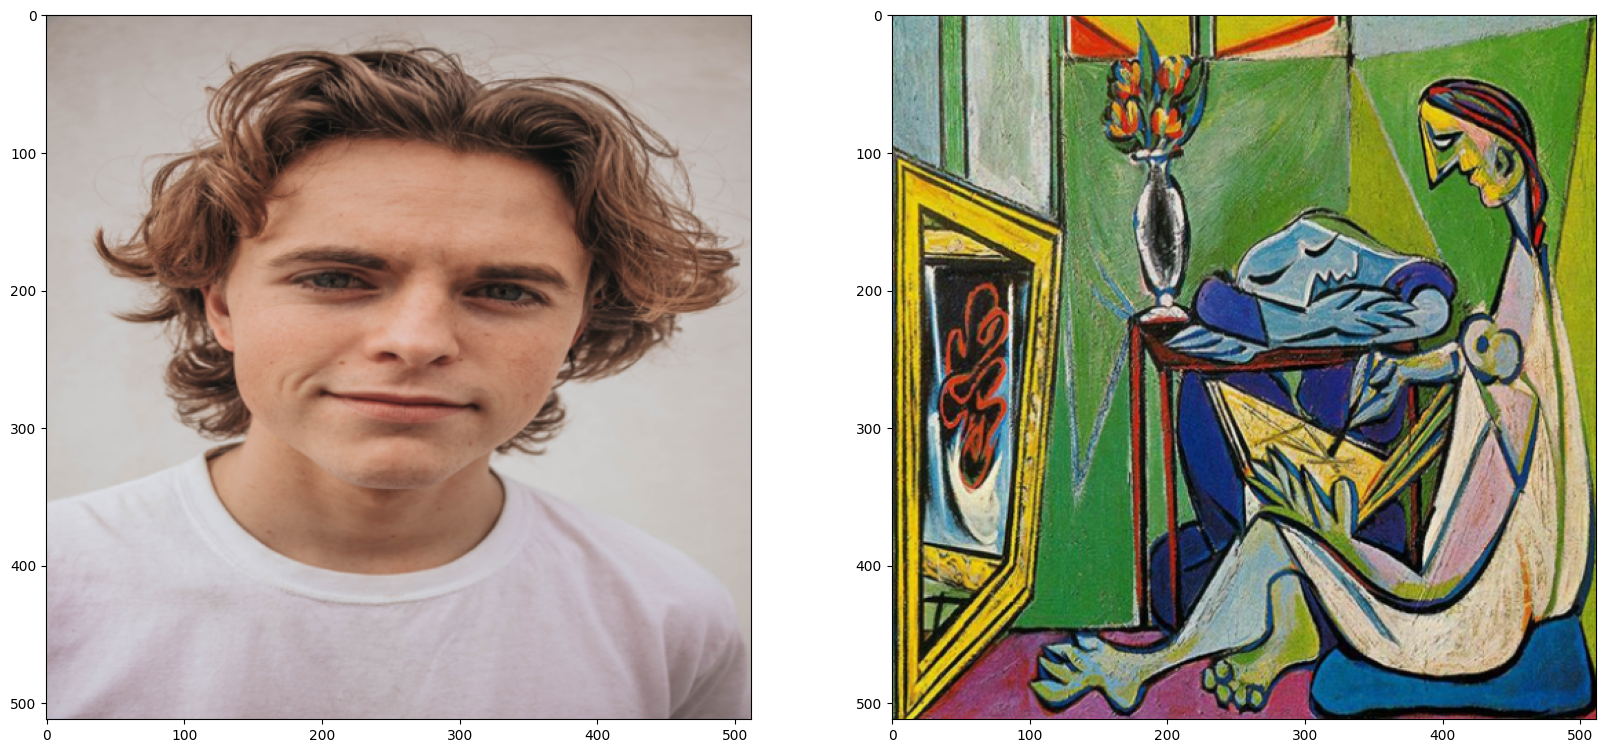

In [34]:
# Presentar las imagenes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
# Poner imagenes de contenido y estilo lado a lado
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

In [35]:
def obtener_carac(imagen, modelo, capas=None):
    ''' Pasar la imagen a travez del modelo y obtener las características para un grupo de capas
        Capas de defecto del VGNet so iguales a las Gatys et al. (2016)'''
    # mapa de los nombres de las capas de PyTorch VGGNet 
    if capas is None:
        capas = {'0'  : 'conv1_1',
                 '5'  : 'conv2_1', 
                 '10' : 'conv3_1',
                 '19' : 'conv4_1',
                 '21' : 'conv4_2',
                 '28' : 'conv5_1'}
        
    características = {}
    x = imagen
        # model.module es un diccionary que contiene todos los módulos en el model
    for nombre, capa, in modelo._modules.items():
        x = capa(x)
        if nombre in capas:
            características[capas[nombre]] = x
    return características

In [36]:
def matriz_Gram(tensor):
    ''' Calcula la Matriz Gram
        https://es.wikipedia.org/wiki/Matriz_de_Gram
    '''
    # Obtener tamaño de lote (batch_size), profundidad (d),altura (h), y anchura (w) del Tensor
    _, d, h, w = tensor.size()
    
    # Remodelar el Tensor para multiplicar sus características por cada canal
    tensor = tensor.view(d, h * w)
    
    # Calcular la Matriz de Gram
    gram = torch.mm(tensor, tensor.t())
    
    return gram

In [37]:
def compute_loss(vgg, content_features, style_grams, target_features, content_weight=1, style_weight=1e6):
    """
    Compute the total loss for neural style transfer given the VGG model, content features, style gram matrices,
    and target image features. 
    
    Args:
    - vgg: VGG model used for feature extraction
    - content_features: Dictionary of content features extracted from the VGG model
    - style_grams: Dictionary of style gram matrices computed from the VGG model
    - target_features: Features of the target image
    - content_weight: Weight of the content loss
    - style_weight: Weight of the style loss
    
    Returns:
    - Total loss value
    """
    # Define the layers to use for content and style representations
    content_layers = ['conv4_2']
    style_layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']
    
    # Get the target features and compute the loss for each layer
    loss = 0
    for layer in content_layers:
        content_feature = content_features[layer]
        target_feature = target_features[layer]
        loss += content_weight * torch.mean((target_feature - content_feature)**2)
        
    for layer in style_layers:
        style_gram = style_grams[layer]
        target_feature = target_features[layer]
        _, c, h, w = target_feature.shape
        target_gram = matriz_Gram(target_feature)
        layer_style_loss = style_weight * torch.mean((target_gram - style_gram)**2)
        loss += layer_style_loss / (c * h * w)
        
    return loss

In [38]:
# Obtener características de contenido y estilo -- solo una vez antes de entrenar a la red
características_contenido = obtener_carac(content, vgg)
características_estilo    = obtener_carac(style, vgg)

# Calcular la matriz de Gram para cada capa de la representación de estilo
grams_estilo = {capa: matriz_Gram(características_estilo[capa]) for capa in características_estilo}

# Crear una tercera imagen 'objetivo' y prepararla para cambios
objetivo = content.clone().requires_grad_(True).to(device)

In [39]:
# Pesos por cada capa del estilo
pesos_estilo = {'conv1_1' : 1,
              'conv2_1' : 0.75,
              'conv3_1' : 0.2,
              'conv4_1' : 0.2,
              'conv5_1' : 0.2}

peso_contenido = 1.0 #alpha
peso_estilo = 1e5  #beta gatus used all the way from  10 to 1e5
#peso_estilo = 1.0  #beta

In [40]:
presentar_cada = 100

# Iterar por los híper-parámetros
optimizer = optim.Adam([objetivo], lr = 0.005) # gatys used from 0.005 - 2
pasos = 300

for ii in range(1, pasos+1):
    # obtener características de la imagen objetivo
    características_objetivo = obtener_carac(objetivo, vgg)
    
    # pérdida en contenido
    pérdida_contenido = torch.mean((características_objetivo['conv4_2'] - características_contenido['conv4_2'])**2)
    
    # pérdida en estilo
    # iniciar la pérdida en estilo en zero
    pérdida_estilo = 0 
    # añadir la pérdida de la matriz de Gram por cada capa
    for capa in pesos_estilo:
        # obtener el estilo de representración del objetivo en cada capa
        característica_objetivo = características_objetivo[capa]
        gram_objetivo = matriz_Gram(característica_objetivo)
        _, d, h, w = característica_objetivo.shape
        # Obtener el 'estilo' en la representación de estilo
        gram_estilo = grams_estilo[capa]
        
        # Pérdida de estilo por capa -- añadiendo peso apropiadamente
        pérdida_capa_estilo = pesos_estilo[capa] * torch.mean((gram_objetivo - gram_estilo)**2)
        # Añadir perdida en estilo
        pérdida_estilo += pérdida_capa_estilo / (d * h* w)
        
    # Calcular pérdida total
    pérdida_total = peso_contenido * pérdida_contenido + peso_estilo * pérdida_estilo
    
    # Actualizar la imagen objetivo
    optimizer.zero_grad()
    pérdida_total.backward()
    optimizer.step()
    
    # Presentar las imagenes intermedias para ver como van cambiando y mostrar la pérdida
    if ii % presentar_cada == 0:
        print("Pérdida Total: ", pérdida_total.item())
        plt.imshow(im_convert(objetivo))
        plt.show()

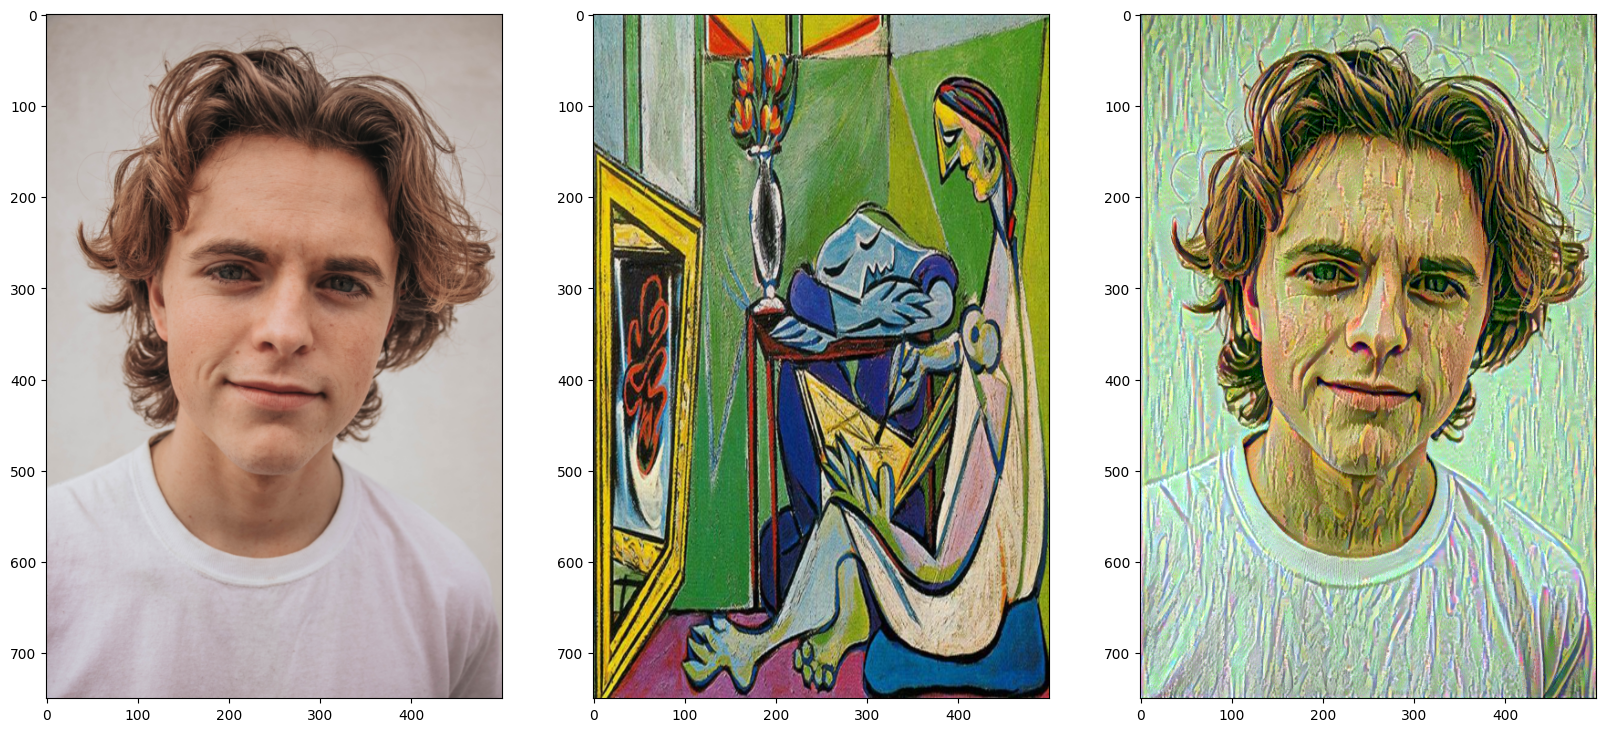

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize = (20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))
ax3.imshow(im_convert(objetivo))

save_image(objetivo, 'output.png')